[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

### Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import time
import gc
import pickle
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from transformers import Wav2Vec2Processor

In [ ]:
import torchaudio

### **Data Preparation**

In [ ]:
class PreprocessedDysfluencyDataset(Dataset):
    def __init__(self, split_data):
        """
        Args:
            split_data: Dictionary containing file_paths, binary_labels, and multi_labels
        """
        self.file_paths = split_data['file_paths']
        self.binary_labels = split_data['binary_labels']
        self.multi_labels = split_data['multi_labels']

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        try:
            # Load preprocessed features with pickle_module=pickle
            inputs = torch.load(self.file_paths[idx], pickle_module=pickle)

            # Handle BatchFeature objects
            if hasattr(inputs, 'data'):
                # If it's a BatchFeature object
                input_values = inputs.data['input_values']
                attention_mask = inputs.data['attention_mask'] if 'attention_mask' in inputs.data else None
            elif isinstance(inputs, dict):
                # If it's a dictionary
                input_values = inputs['input_values']
                attention_mask = inputs['attention_mask'] if 'attention_mask' in inputs else None
            else:
                # Unexpected structure
                print(f"Unexpected input type: {type(inputs)}")
                raise ValueError(f"Unsupported input type: {type(inputs)}")

            # Ensure tensors
            if not isinstance(input_values, torch.Tensor):
                input_values = torch.tensor(input_values)

            if attention_mask is not None and not isinstance(attention_mask, torch.Tensor):
                attention_mask = torch.tensor(attention_mask)
            else:
                # Create default attention mask if none exists
                attention_mask = torch.ones_like(input_values[:1])

            # Get labels
            binary_label = torch.tensor([self.binary_labels[idx]], dtype=torch.float)
            multi_labels = torch.tensor(self.multi_labels[idx], dtype=torch.float)

            return {
                'input_values': input_values.squeeze(0),
                'attention_mask': attention_mask.squeeze(0),
                'multi_labels': multi_labels,
                'binary_label': binary_label
            }

        except Exception as e:
            print(f"Error loading file {self.file_paths[idx]}: {e}")
            # Create fallback tensors for errors
            input_values = torch.zeros(16000)  # Adjust size as needed
            attention_mask = torch.ones(16000)  # Adjust size as needed
            binary_label = torch.tensor([self.binary_labels[idx]], dtype=torch.float)
            multi_labels = torch.tensor(self.multi_labels[idx], dtype=torch.float)

            return {
                'input_values': input_values,
                'attention_mask': attention_mask,
                'multi_labels': multi_labels,
                'binary_label': binary_label
            }

In [ ]:
def combine_datasets(sep28k_dir, fluencybank_dir, output_dir='/content/combined_features'):
    """
    Combine SEP-28k and FluencyBank datasets, keeping test sets separate
    """
    os.makedirs(output_dir, exist_ok=True)

    # Load SEP-28k data with path updates
    with open(f'{sep28k_dir}/train_data.pkl', 'rb') as f:
        sep28k_train = pickle.load(f)
        sep28k_train = update_file_paths(sep28k_train, f'{sep28k_dir}/train')

    with open(f'{sep28k_dir}/val_data.pkl', 'rb') as f:
        sep28k_val = pickle.load(f)
        sep28k_val = update_file_paths(sep28k_val, f'{sep28k_dir}/val')

    with open(f'{sep28k_dir}/test_data.pkl', 'rb') as f:
        sep28k_test = pickle.load(f)
        sep28k_test = update_file_paths(sep28k_test, f'{sep28k_dir}/test')

    # Load FluencyBank data with path updates
    with open(f'{fluencybank_dir}/train_data.pkl', 'rb') as f:
        fluencybank_train = pickle.load(f)
        fluencybank_train = update_file_paths(fluencybank_train, f'{fluencybank_dir}/train')

    with open(f'{fluencybank_dir}/val_data.pkl', 'rb') as f:
        fluencybank_val = pickle.load(f)
        fluencybank_val = update_file_paths(fluencybank_val, f'{fluencybank_dir}/val')

    with open(f'{fluencybank_dir}/test_data.pkl', 'rb') as f:
        fluencybank_test = pickle.load(f)
        fluencybank_test = update_file_paths(fluencybank_test, f'{fluencybank_dir}/test')

    # Combine train and validation sets
    combined_train = {
        'file_paths': sep28k_train['file_paths'] + fluencybank_train['file_paths'],
        'binary_labels': sep28k_train['binary_labels'] + fluencybank_train['binary_labels'],
        'multi_labels': sep28k_train['multi_labels'] + fluencybank_train['multi_labels']
    }

    combined_val = {
        'file_paths': sep28k_val['file_paths'] + fluencybank_val['file_paths'],
        'binary_labels': sep28k_val['binary_labels'] + fluencybank_val['binary_labels'],
        'multi_labels': sep28k_val['multi_labels'] + fluencybank_val['multi_labels']
    }

    # Save combined datasets
    with open(f'{output_dir}/train_data.pkl', 'wb') as f:
        pickle.dump(combined_train, f)

    with open(f'{output_dir}/val_data.pkl', 'wb') as f:
        pickle.dump(combined_val, f)

    # Save separate test sets
    with open(f'{output_dir}/sep28k_test_data.pkl', 'wb') as f:
        pickle.dump(sep28k_test, f)

    with open(f'{output_dir}/fluencybank_test_data.pkl', 'wb') as f:
        pickle.dump(fluencybank_test, f)

    # Load and save label info - verify compatibility first
    with open(f'{sep28k_dir}/label_info.json', 'r') as f:
        sep28k_label_info = json.load(f)

    with open(f'{fluencybank_dir}/label_info.json', 'r') as f:
        fluencybank_label_info = json.load(f)

    # Check if label names are compatible
    if sep28k_label_info['label_names'] != fluencybank_label_info['label_names']:
        print("Warning: Label names differ between datasets!")
        print(f"SEP-28k: {sep28k_label_info['label_names']}")
        print(f"FluencyBank: {fluencybank_label_info['label_names']}")

        # Use SEP-28k label info but notify users about the potential issues
        print("Using SEP-28k label names for consistency.")

    print(f"SEP-28k: {sep28k_label_info['label_names']}")
    print(f"FluencyBank: {fluencybank_label_info['label_names']}")
    # Use SEP-28k label info for consistency
    with open(f'{output_dir}/label_info.json', 'w') as f:
        json.dump(sep28k_label_info, f)

    # Calculate combined class weights
    combined_weights = {}
    total_samples = len(combined_train['binary_labels'])

    for i, label in enumerate(sep28k_label_info['label_names']):
        positive_count = sum(1 for labels in combined_train['multi_labels'] if labels[i] == 1)
        weight = total_samples / (2 * positive_count) if positive_count > 0 else 1.0
        combined_weights[label] = float(weight)

    with open(f'{output_dir}/class_weights.json', 'w') as f:
        json.dump(combined_weights, f)

    print(f"Combined dataset created in {output_dir}")
    print(f"Training samples: {len(combined_train['binary_labels'])}")
    print(f"Validation samples: {len(combined_val['binary_labels'])}")
    print(f"SEP-28k test samples: {len(sep28k_test['binary_labels'])}")
    print(f"FluencyBank test samples: {len(fluencybank_test['binary_labels'])}")

    return output_dir

In [ ]:
def combine_datasets(sep28k_dir, fluencybank_dir, output_dir='/content/combined_features'):
    """
    Combine SEP-28k and FluencyBank datasets, keeping test sets separate
    """
    os.makedirs(output_dir, exist_ok=True)

    # Load SEP-28k data with path updates
    with open(f'{sep28k_dir}/train_data.pkl', 'rb') as f:
        sep28k_train = pickle.load(f)
        sep28k_train = update_file_paths(sep28k_train, f'{sep28k_dir}/train')

    with open(f'{sep28k_dir}/val_data.pkl', 'rb') as f:
        sep28k_val = pickle.load(f)
        sep28k_val = update_file_paths(sep28k_val, f'{sep28k_dir}/val')

    with open(f'{sep28k_dir}/test_data.pkl', 'rb') as f:
        sep28k_test = pickle.load(f)
        sep28k_test = update_file_paths(sep28k_test, f'{sep28k_dir}/test')

    # Load FluencyBank data with path updates
    with open(f'{fluencybank_dir}/train_data.pkl', 'rb') as f:
        fluencybank_train = pickle.load(f)
        fluencybank_train = update_file_paths(fluencybank_train, f'{fluencybank_dir}/train')

    with open(f'{fluencybank_dir}/val_data.pkl', 'rb') as f:
        fluencybank_val = pickle.load(f)
        fluencybank_val = update_file_paths(fluencybank_val, f'{fluencybank_dir}/val')

    with open(f'{fluencybank_dir}/test_data.pkl', 'rb') as f:
        fluencybank_test = pickle.load(f)
        fluencybank_test = update_file_paths(fluencybank_test, f'{fluencybank_dir}/test')

    # Combine train and validation sets
    combined_train = {
        'file_paths': sep28k_train['file_paths'] + fluencybank_train['file_paths'],
        'binary_labels': sep28k_train['binary_labels'] + fluencybank_train['binary_labels'],
        'multi_labels': sep28k_train['multi_labels'] + fluencybank_train['multi_labels']
    }

    combined_val = {
        'file_paths': sep28k_val['file_paths'] + fluencybank_val['file_paths'],
        'binary_labels': sep28k_val['binary_labels'] + fluencybank_val['binary_labels'],
        'multi_labels': sep28k_val['multi_labels'] + fluencybank_val['multi_labels']
    }

    # Save combined datasets
    with open(f'{output_dir}/train_data.pkl', 'wb') as f:
        pickle.dump(combined_train, f)

    with open(f'{output_dir}/val_data.pkl', 'wb') as f:
        pickle.dump(combined_val, f)

    # Save separate test sets
    with open(f'{output_dir}/sep28k_test_data.pkl', 'wb') as f:
        pickle.dump(sep28k_test, f)

    with open(f'{output_dir}/fluencybank_test_data.pkl', 'wb') as f:
        pickle.dump(fluencybank_test, f)

    # Load and save label info - verify compatibility first
    with open(f'{sep28k_dir}/label_info.json', 'r') as f:
        sep28k_label_info = json.load(f)

    with open(f'{fluencybank_dir}/label_info.json', 'r') as f:
        fluencybank_label_info = json.load(f)

    # Check if label names are compatible
    if sep28k_label_info['label_names'] != fluencybank_label_info['label_names']:
        print("Warning: Label names differ between datasets!")
        print(f"SEP-28k: {sep28k_label_info['label_names']}")
        print(f"FluencyBank: {fluencybank_label_info['label_names']}")

        # Use SEP-28k label info but notify users about the potential issues
        print("Using SEP-28k label names for consistency.")

    # Use SEP-28k label info for consistency
    with open(f'{output_dir}/label_info.json', 'w') as f:
        json.dump(sep28k_label_info, f)

    # Calculate combined class weights
    combined_weights = {}
    total_samples = len(combined_train['binary_labels'])

    for i, label in enumerate(sep28k_label_info['label_names']):
        positive_count = sum(1 for labels in combined_train['multi_labels'] if labels[i] == 1)
        weight = total_samples / (2 * positive_count) if positive_count > 0 else 1.0
        combined_weights[label] = float(weight)

    with open(f'{output_dir}/class_weights.json', 'w') as f:
        json.dump(combined_weights, f)

    print(f"Combined dataset created in {output_dir}")
    print(f"Training samples: {len(combined_train['binary_labels'])}")
    print(f"Validation samples: {len(combined_val['binary_labels'])}")
    print(f"SEP-28k test samples: {len(sep28k_test['binary_labels'])}")
    print(f"FluencyBank test samples: {len(fluencybank_test['binary_labels'])}")

    return output_dir

Model

In [ ]:
class DysfluencyTransformerModel(nn.Module):
    def __init__(self, num_specific_labels=4, dropout=0.1):
        super(DysfluencyTransformerModel, self).__init__()

        # Load pre-trained Wav2Vec2 model
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

        # Freeze the feature extractor (first few layers) of Wav2Vec2
        for param in self.wav2vec2.feature_extractor.parameters():
            param.requires_grad = False

        # Get hidden size from Wav2Vec2 config
        hidden_size = self.wav2vec2.config.hidden_size

        # Transformer encoder layers for sequence modeling
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8,
                                       dim_feedforward=hidden_size*4, dropout=dropout),
            num_layers=2
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        # Shared feature extraction
        self.shared_features = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Binary classifier for fluent/dysfluent
        self.binary_classifier = nn.Linear(hidden_size, 1)

        # Multi-label classifier for specific dysfluencies
        self.multi_classifier = nn.Linear(hidden_size, num_specific_labels)

    def forward(self, input_values, attention_mask=None):
        # Get Wav2Vec2 embeddings
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch_size, sequence_length, hidden_size]

        # Apply transformer encoder (expects [sequence_length, batch_size, hidden_size])
        hidden_states = hidden_states.transpose(0, 1)
        transformer_output = self.transformer_encoder(hidden_states)
        transformer_output = transformer_output.transpose(0, 1)  # [batch_size, sequence_length, hidden_size]

        # Apply attention to focus on relevant parts
        attention_weights = self.attention(transformer_output)  # [batch_size, sequence_length, 1]
        context_vector = torch.sum(attention_weights * transformer_output, dim=1)  # [batch_size, hidden_size]

        # Apply shared feature extraction
        shared_features = self.shared_features(context_vector)

        # Get binary classification logits
        binary_logits = self.binary_classifier(shared_features)  # [batch_size, 1]

        # Get multi-label classification logits
        multi_logits = self.multi_classifier(shared_features)  # [batch_size, num_specific_labels]

        return binary_logits, multi_logits

Train

In [ ]:
def train_model(model, train_dataloader, val_dataloader, device,
                num_epochs=5, learning_rate=1e-4,
                binary_criterion=None, multi_criterion=None,
                save_path='best_dysfluency_model.pt'):
    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Initialize loss functions if not provided
    if binary_criterion is None:
        binary_criterion = nn.BCEWithLogitsLoss()
    if multi_criterion is None:
        multi_criterion = nn.BCEWithLogitsLoss()

    # Initialize best metrics for model checkpointing
    best_val_f1 = 0.0

    # Track metrics for plotting
    train_losses = []
    val_losses = []
    val_binary_f1_scores = []
    val_multi_f1_scores = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_binary_loss = 0.0
        train_multi_loss = 0.0

        # Training loop
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for batch in progress_bar:
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device) if batch['attention_mask'] is not None else None
            binary_label = batch['binary_label'].to(device)
            multi_labels = batch['multi_labels'].to(device)

            optimizer.zero_grad()

            binary_logits, multi_logits = model(input_values, attention_mask)

            # Calculate losses
            binary_loss = binary_criterion(binary_logits, binary_label)
            multi_loss = multi_criterion(multi_logits, multi_labels)

            # Combine losses (you can adjust the weights if needed)
            total_loss = binary_loss + multi_loss

            total_loss.backward()
            optimizer.step()

            train_binary_loss += binary_loss.item()
            train_multi_loss += multi_loss.item()

            progress_bar.set_postfix({
                'binary_loss': f"{binary_loss.item():.4f}",
                'multi_loss': f"{multi_loss.item():.4f}"
            })

            # Clear GPU cache if necessary
            del input_values, attention_mask, binary_label, multi_labels, binary_logits, multi_logits
            torch.cuda.empty_cache()

        avg_train_binary_loss = train_binary_loss / len(train_dataloader)
        avg_train_multi_loss = train_multi_loss / len(train_dataloader)
        avg_train_total_loss = avg_train_binary_loss + avg_train_multi_loss

        # Validation loop
        val_metrics = evaluate_model(model, val_dataloader, device, binary_criterion, multi_criterion)

        # Save metrics for plotting
        train_losses.append(avg_train_total_loss)
        val_losses.append(val_metrics['binary_loss'] + val_metrics['multi_loss'])
        val_binary_f1_scores.append(val_metrics['binary_f1'])
        val_multi_f1_scores.append(val_metrics['multi_f1'])

        # Print metrics
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {elapsed_time:.2f}s")
        print(f"Train Binary Loss: {avg_train_binary_loss:.4f}")
        print(f"Train Multi Loss: {avg_train_multi_loss:.4f}")
        print(f"Validation Binary Loss: {val_metrics['binary_loss']:.4f}")
        print(f"Validation Multi Loss: {val_metrics['multi_loss']:.4f}")
        print(f"Validation Binary Accuracy: {val_metrics['binary_accuracy']:.4f}")
        print(f"Validation Binary F1: {val_metrics['binary_f1']:.4f}")
        print(f"Validation Multi F1: {val_metrics['multi_f1']:.4f}")

        # Save the best model based on multi-label F1 score
        if val_metrics['multi_f1'] > best_val_f1:
            best_val_f1 = val_metrics['multi_f1']
            torch.save(model.state_dict(), save_path)
            print("Saved new best model!")

        # Run garbage collection
        gc.collect()
        torch.cuda.empty_cache()

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_binary_f1_scores, label='Binary F1')
    plt.plot(val_multi_f1_scores, label='Multi-label F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Validation F1 Scores')

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

    print("Training complete!")
    return model


In [ ]:
def train_model(model, train_dataloader, val_dataloader, device,
                num_epochs=5, learning_rate=1e-4,
                binary_criterion=None, multi_criterion=None,
                save_path='best_dysfluency_model.pt'):
    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Initialize loss functions if not provided
    if binary_criterion is None:
        binary_criterion = nn.BCEWithLogitsLoss()
    if multi_criterion is None:
        multi_criterion = nn.BCEWithLogitsLoss()

    # Initialize best metrics for model checkpointing
    best_val_f1 = 0.0

    # Track metrics for plotting
    train_losses = []
    val_losses = []

    # Binary classification metrics
    train_binary_accuracies = []
    val_binary_accuracies = []

    # Multi-label classification metrics (for each dysfluency type)
    # label_names = None  # Will be populated during evaluation # C
    train_multi_accuracies_by_type = {}
    val_multi_accuracies_by_type = {}
    label_names = ["Repetition", "Prolongation", "Block", "Interjection"] # C
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_binary_loss = 0.0
        train_multi_loss = 0.0

        # For binary accuracy tracking during training
        train_binary_correct = 0
        train_binary_total = 0

        # For multi-label accuracy tracking during training
        train_multi_correct_by_type = None  # Will initialize after getting label_names

        # Training loop
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for batch in progress_bar:
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device) if batch['attention_mask'] is not None else None
            binary_label = batch['binary_label'].to(device)
            multi_labels = batch['multi_labels'].to(device)

            # Initialize multi-label tracking if not done yet
            # if label_names is None and hasattr(val_dataloader.dataset, 'label_names'): # C
            #     label_names = val_dataloader.dataset.label_names # C
            # elif label_names is None and multi_labels.size(1) > 0: # C
            #     label_names = [f"Type_{i}" for i in range(multi_labels.size(1))] # C

            if train_multi_correct_by_type is None and label_names is not None:
                train_multi_correct_by_type = {label: 0 for label in label_names}
                train_multi_total_by_type = {label: 0 for label in label_names}

                # Initialize the tracking dictionaries for plots if not done yet
                if not train_multi_accuracies_by_type:
                    for label in label_names:
                        train_multi_accuracies_by_type[label] = []
                        val_multi_accuracies_by_type[label] = []

            optimizer.zero_grad()

            binary_logits, multi_logits = model(input_values, attention_mask)

            # Calculate losses
            binary_loss = binary_criterion(binary_logits, binary_label)
            multi_loss = multi_criterion(multi_logits, multi_labels)

            # Combine losses
            total_loss = binary_loss + multi_loss

            total_loss.backward()
            optimizer.step()

            train_binary_loss += binary_loss.item()
            train_multi_loss += multi_loss.item()

            # Calculate binary accuracy during training
            binary_preds = (torch.sigmoid(binary_logits) >= 0.5).float()
            train_binary_correct += (binary_preds == binary_label).sum().item()
            train_binary_total += binary_label.size(0)

            # Calculate multi-label accuracies during training
            multi_preds = (torch.sigmoid(multi_logits) >= 0.5).float()
            for i, label in enumerate(label_names):
                train_multi_correct_by_type[label] += ((multi_preds[:, i] == multi_labels[:, i]).sum().item())
                train_multi_total_by_type[label] += multi_labels.size(0)

            progress_bar.set_postfix({
                'binary_loss': f"{binary_loss.item():.4f}",
                'multi_loss': f"{multi_loss.item():.4f}"
            })

            # Clear GPU cache if necessary
            del input_values, attention_mask, binary_label, multi_labels, binary_logits, multi_logits
            torch.cuda.empty_cache()

        # Calculate average losses and accuracies
        avg_train_binary_loss = train_binary_loss / len(train_dataloader)
        avg_train_multi_loss = train_multi_loss / len(train_dataloader)
        avg_train_total_loss = avg_train_binary_loss + avg_train_multi_loss

        # Calculate and store training accuracies
        train_binary_accuracy = train_binary_correct / train_binary_total
        train_binary_accuracies.append(train_binary_accuracy)

        # Store multi-label accuracies by type
        for label in label_names:
            label_accuracy = train_multi_correct_by_type[label] / train_multi_total_by_type[label]
            train_multi_accuracies_by_type[label].append(label_accuracy)

        # Validation loop
        val_metrics = evaluate_model(model, val_dataloader, device, binary_criterion, multi_criterion)

        # Save metrics for plotting
        train_losses.append(avg_train_total_loss)
        val_losses.append(val_metrics['binary_loss'] + val_metrics['multi_loss'])
        val_binary_accuracies.append(val_metrics['binary_accuracy'])

        # Store validation accuracies by dysfluency type
        for i, label in enumerate(label_names):
            if f'accuracy_{label}' in val_metrics:
                val_multi_accuracies_by_type[label].append(val_metrics[f'accuracy_{label}'])
            else:
                # If not available directly, calculate from predictions
                val_multi_accuracies_by_type[label].append(val_metrics.get(f'accuracy_{i}', 0.5))  # Default to 0.5 if not found

        # Print metrics
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {elapsed_time:.2f}s")
        print(f"Train Binary Loss: {avg_train_binary_loss:.4f}, Train Binary Accuracy: {train_binary_accuracy:.4f}")
        print(f"Train Multi Loss: {avg_train_multi_loss:.4f}")
        print(f"Validation Binary Loss: {val_metrics['binary_loss']:.4f}, Val Binary Accuracy: {val_metrics['binary_accuracy']:.4f}")
        print(f"Validation Multi Loss: {val_metrics['multi_loss']:.4f}")
        print(f"Validation Binary F1: {val_metrics['binary_f1']:.4f}")
        print(f"Validation Multi F1: {val_metrics['multi_f1']:.4f}")

        # Save the best model based on multi-label F1 score
        if val_metrics['multi_f1'] > best_val_f1:
            best_val_f1 = val_metrics['multi_f1']
            torch.save(model.state_dict(), save_path)
            print("Saved new best model!")

        # Run garbage collection
        gc.collect()
        torch.cuda.empty_cache()

    # Plot training curves
    # plt.figure(figsize=(12, 8))

    # # Plot 1: Loss curves
    # plt.subplot(2, 2, 1)
    # plt.plot(train_losses, label='Train Loss')
    # plt.plot(val_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Training and Validation Loss')

    # # Plot 2: Binary accuracy curves
    # plt.subplot(2, 2, 2)
    # plt.plot(train_binary_accuracies, label='Train Binary Accuracy')
    # plt.plot(val_binary_accuracies, label='Validation Binary Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.title('Binary Classification Accuracy')

    # # Plot 3: All dysfluency types in one plot (validation)
    # plt.subplot(2, 2, 3)
    # for label in label_names:
    #     plt.plot(val_multi_accuracies_by_type[label], label=f'Val {label}')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.title('Validation Accuracy by Dysfluency Type')

    # # Plot 4: All dysfluency types in one plot (training)
    # plt.subplot(2, 2, 4)
    # for label in label_names:
    #     plt.plot(train_multi_accuracies_by_type[label], label=f'Train {label}')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.title('Training Accuracy by Dysfluency Type')

    # plt.tight_layout()
    # plt.savefig('training_curves.png')
    # plt.show()

    # # Additionally, create individual plots for each dysfluency type
    # for label in label_names:
    #     plt.figure(figsize=(8, 6))
    #     plt.plot(train_multi_accuracies_by_type[label], label=f'Train {label}')
    #     plt.plot(val_multi_accuracies_by_type[label], label=f'Val {label}')
    #     plt.xlabel('Epoch')
    #     plt.ylabel('Accuracy')
    #     plt.legend()
    #     plt.title(f'Accuracy for {label}')
    #     plt.tight_layout()
    #     plt.savefig(f'accuracy_{label}.png')
    #     plt.close()

    # Plot training curves - each as a separate plot

    # Plot 1: Loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.savefig('loss_curves.png')
    plt.close()

    # Plot 2: Binary accuracy curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_binary_accuracies, label='Train Binary Accuracy')
    plt.plot(val_binary_accuracies, label='Validation Binary Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Binary Classification Accuracy')
    plt.tight_layout()
    plt.savefig('binary_accuracy_curves.png')
    plt.close()

    # Plot 3: All dysfluency types in one plot (validation)
    #label_names = ["Repetition", "Prolongation", "Block", "Interjection"]
    plt.figure(figsize=(10, 6))
    for label in label_names:
        plt.plot(val_multi_accuracies_by_type[label], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy by Dysfluency Type')
    plt.tight_layout()
    plt.savefig('validation_accuracy_by_type.png')
    plt.close()

    # Plot 4: All dysfluency types in one plot (training)
    plt.figure(figsize=(10, 6))
    for label in label_names:
        plt.plot(train_multi_accuracies_by_type[label], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy by Dysfluency Type')
    plt.tight_layout()
    plt.savefig('training_accuracy_by_type.png')
    plt.close()

    # Additionally, create individual plots for each dysfluency type
    for label in label_names:
        plt.figure(figsize=(8, 6))
        plt.plot(train_multi_accuracies_by_type[label], label=f'Training')
        plt.plot(val_multi_accuracies_by_type[label], label=f'Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'{label}')
        plt.tight_layout()
        plt.savefig(f'accuracy_{label}.png')
        plt.close()

    print("Training complete!")
    return model

In [ ]:
# # Plot training curves - each as a separate plot

#     # Plot 1: Loss curves
#     plt.figure(figsize=(10, 6))
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation Loss')
#     plt.tight_layout()
#     plt.savefig('loss_curves.png')
#     plt.close()

#     # Plot 2: Binary accuracy curves
#     plt.figure(figsize=(10, 6))
#     plt.plot(train_binary_accuracies, label='Train Binary Accuracy')
#     plt.plot(val_binary_accuracies, label='Validation Binary Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.title('Binary Classification Accuracy')
#     plt.tight_layout()
#     plt.savefig('binary_accuracy_curves.png')
#     plt.close()

#     # Plot 3: All dysfluency types in one plot (validation)
#     plt.figure(figsize=(10, 6))
#     for label in label_names:
#         plt.plot(val_multi_accuracies_by_type[label], label=f'Val {label}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.title('Validation Accuracy by Dysfluency Type')
#     plt.tight_layout()
#     plt.savefig('validation_accuracy_by_type.png')
#     plt.close()

#     # Plot 4: All dysfluency types in one plot (training)
#     plt.figure(figsize=(10, 6))
#     for label in label_names:
#         plt.plot(train_multi_accuracies_by_type[label], label=f'Train {label}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.title('Training Accuracy by Dysfluency Type')
#     plt.tight_layout()
#     plt.savefig('training_accuracy_by_type.png')
#     plt.close()

#     # Additionally, create individual plots for each dysfluency type
#     for label in label_names:
#         plt.figure(figsize=(8, 6))
#         plt.plot(train_multi_accuracies_by_type[label], label=f'Train {label}')
#         plt.plot(val_multi_accuracies_by_type[label], label=f'Val {label}')
#         plt.xlabel('Epoch')
#         plt.ylabel('Accuracy')
#         plt.legend()
#         plt.title(f'Accuracy for {label}')
#         plt.tight_layout()
#         plt.savefig(f'accuracy_{label}.png')
#         plt.close()

In [ ]:
def evaluate_model(model, dataloader, device, binary_criterion=None, multi_criterion=None):
    model.eval()
    binary_loss = 0.0
    multi_loss = 0.0

    all_binary_preds = []
    all_binary_labels = []
    all_multi_preds = []
    all_multi_labels = []
    all_multi_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device) if batch['attention_mask'] is not None else None
            binary_label = batch['binary_label'].to(device)
            multi_labels = batch['multi_labels'].to(device)

            binary_logits, multi_logits = model(input_values, attention_mask)

            if binary_criterion is not None and multi_criterion is not None:
                b_loss = binary_criterion(binary_logits, binary_label)
                m_loss = multi_criterion(multi_logits, multi_labels)
                binary_loss += b_loss.item()
                multi_loss += m_loss.item()

            # Convert logits to probabilities and binary predictions
            binary_probs = torch.sigmoid(binary_logits).cpu().numpy()
            binary_preds = (binary_probs >= 0.5).astype(int)

            multi_probs = torch.sigmoid(multi_logits).cpu().numpy()
            multi_preds = (multi_probs >= 0.5).astype(int)

            all_binary_preds.append(binary_preds)
            all_binary_labels.append(binary_label.cpu().numpy())
            all_multi_preds.append(multi_preds)
            all_multi_labels.append(multi_labels.cpu().numpy())
            all_multi_probs.append(multi_probs)

    # Concatenate batches
    all_binary_preds = np.vstack(all_binary_preds)
    all_binary_labels = np.vstack(all_binary_labels)
    all_multi_preds = np.vstack(all_multi_preds)
    all_multi_labels = np.vstack(all_multi_labels)
    all_multi_probs = np.vstack(all_multi_probs)

    # Calculate binary classification metrics
    binary_metrics = {
        'binary_accuracy': accuracy_score(all_binary_labels, all_binary_preds),
        'binary_f1': f1_score(all_binary_labels, all_binary_preds, average='binary', zero_division=0),
        'binary_precision': precision_score(all_binary_labels, all_binary_preds, average='binary', zero_division=0),
        'binary_recall': recall_score(all_binary_labels, all_binary_preds, average='binary', zero_division=0)
    }

    # Calculate multi-label classification metrics
    multi_metrics = {
        'multi_f1': f1_score(all_multi_labels, all_multi_preds, average='macro', zero_division=0),
        'multi_precision': precision_score(all_multi_labels, all_multi_preds, average='macro', zero_division=0),
        'multi_recall': recall_score(all_multi_labels, all_multi_preds, average='macro', zero_division=0)
    }
    print(f"Testing: bin f1 {binary_metrics['binary_f1']}, mul f1 {multi_metrics['multi_f1']}")


    # Calculate metrics per dysfluency class
    with open('/content/drive/MyDrive/mfcc_features/processed_features/label_info.json', 'r') as f:
        label_info = json.load(f)

    label_names = label_info['label_names']
    for i, label in enumerate(label_names):
        multi_metrics[f'f1_{label}'] = f1_score(all_multi_labels[:, i], all_multi_preds[:, i], zero_division=0)
        multi_metrics[f'accuracy_{label}'] = accuracy_score(all_multi_labels[:, i], all_multi_preds[:, i])
        multi_metrics[f'precision_{label}'] = precision_score(all_multi_labels[:, i], all_multi_preds[:, i], zero_division=0)
        multi_metrics[f'recall_{label}'] = recall_score(all_multi_labels[:, i], all_multi_preds[:, i], zero_division=0)

        # Calculate UAR (Unweighted Average Recall)
        tn, fp, fn, tp = confusion_matrix(all_multi_labels[:, i], all_multi_preds[:, i], labels=[0, 1]).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        multi_metrics[f'uar_{label}'] = (sensitivity + specificity) / 2

        # Calculate mAP (mean Average Precision)
        try:
            multi_metrics[f'map_{label}'] = average_precision_score(all_multi_labels[:, i], all_multi_probs[:, i])
        except Exception as e:
            print(f"Error calculating mAP for {label}: {e}")
            multi_metrics[f'map_{label}'] = 0.0
    # Combine metrics
    metrics = {**binary_metrics, **multi_metrics}

    if binary_criterion is not None and multi_criterion is not None:
        metrics['binary_loss'] = binary_loss / len(dataloader)
        metrics['multi_loss'] = multi_loss / len(dataloader)

    return metrics

Plot CM

In [ ]:
def plot_confusion_matrices_with_prefix(model, test_dataloader, device, label_names, prefix):
    """Same as plot_confusion_matrices but adds a prefix to saved filenames"""
    # [Keeping the data collection part unchanged]
    model.eval()
    all_binary_preds = []
    all_binary_labels = []
    all_multi_preds = []
    all_multi_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Generating predictions for confusion matrices"):
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device) if batch['attention_mask'] is not None else None
            binary_label = batch['binary_label'].to(device)
            multi_labels = batch['multi_labels'].to(device)

            binary_logits, multi_logits = model(input_values, attention_mask)

            # Convert logits to probabilities and binary predictions
            binary_probs = torch.sigmoid(binary_logits).cpu().numpy()
            binary_preds = (binary_probs >= 0.5).astype(int)

            multi_probs = torch.sigmoid(multi_logits).cpu().numpy()
            multi_preds = (multi_probs >= 0.5).astype(int)

            all_binary_preds.append(binary_preds)
            all_binary_labels.append(binary_label.cpu().numpy())
            all_multi_preds.append(multi_preds)
            all_multi_labels.append(multi_labels.cpu().numpy())

    all_binary_preds = np.vstack(all_binary_preds)
    all_binary_labels = np.vstack(all_binary_labels)
    all_multi_preds = np.vstack(all_multi_preds)
    all_multi_labels = np.vstack(all_multi_labels)

    # Plot binary confusion matrix
    plt.figure(figsize=(6, 5))
    binary_cm = confusion_matrix(all_binary_labels, all_binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=binary_cm, display_labels=['Dysfluent', 'Fluent'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Binary Classification: Fluent vs Dysfluent')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{prefix}_binary_confusion_matrix.png')
    plt.close()  # Close the figure to avoid overlapping plots

    # Plot confusion matrix for each dysfluency type - one at a time
    for i, label in enumerate(label_names):
        plt.figure(figsize=(6, 5))  # Create a new figure for each plot
        cm = confusion_matrix(all_multi_labels[:, i], all_multi_preds[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Classification: {label}')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{prefix}_{label}_confusion_matrix.png')
        plt.close()  # Close each figure after saving

    # If you still want a combined figure, create it separately
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    for i, label in enumerate(label_names):
        if i < len(axes):  # Safety check
            cm = confusion_matrix(all_multi_labels[:, i], all_multi_preds[:, i])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
            disp.plot(ax=axes[i], cmap=plt.cm.Blues)
            axes[i].set_title(f'Classification: {label}')

    plt.tight_layout()
    plt.show()
    plt.savefig(f'{prefix}_multi_confusion_matrices.png')
    plt.close()

In [ ]:
def update_file_paths(data_dict, new_base_path):
    """
    Update file paths in the data dictionary to match the new location in Colab
    """
    updated_paths = []
    for path in data_dict['file_paths']:
        # Extract just the filename from the path
        filename = os.path.basename(path)
        # Construct new path
        new_path = os.path.join(new_base_path, filename)
        updated_paths.append(new_path)

    # Update the data dictionary
    data_dict['file_paths'] = updated_paths
    return data_dict

# # Then modify your data loading code
# with open('/content/drive/MyDrive/mfcc_features/processed_features/train_data.pkl', 'rb') as f:
#     train_data = pickle.load(f)
#     # Update paths to match your Colab structure
#     train_data = update_file_paths(train_data, '/content/drive/MyDrive/mfcc_features/processed_features/train')

# with open('/content/drive/MyDrive/mfcc_features/processed_features/val_data.pkl', 'rb') as f:
#     val_data = pickle.load(f)
#     val_data = update_file_paths(val_data, '/content/drive/MyDrive/mfcc_features/processed_features/val')

# with open('/content/drive/MyDrive/mfcc_features/processed_features/test_data.pkl', 'rb') as f:
#     test_data = pickle.load(f)
#     test_data = update_file_paths(test_data, '/content/drive/MyDrive/mfcc_features/processed_features/test')

In [ ]:
torch.serialization.add_safe_globals(['transformers.feature_extraction_utils.BatchFeature'])

In [ ]:
def custom_collate(batch):
    """
    Custom collate function to handle potential errors in batch items
    """
    # Filter out any None values
    batch = [item for item in batch if item is not None]

    if len(batch) == 0:
        # Return empty tensors if all items were invalid
        return {
            'input_values': torch.tensor([]),
            'attention_mask': torch.tensor([]),
            'multi_labels': torch.tensor([]),
            'binary_label': torch.tensor([])
        }

    # Check if all items have the expected keys
    keys = batch[0].keys()
    for item in batch:
        if set(item.keys()) != set(keys):
            print(f"Inconsistent keys in batch items: {item.keys()} vs {keys}")

    # Create a new batch with only valid items
    result = {}
    for key in keys:
        try:
            # Pad sequences if necessary
            if key in ['input_values', 'attention_mask']:
                # Get max sequence length in this batch
                max_len = max(x[key].shape[0] for x in batch)
                # Pad each sequence to max_len
                padded = [torch.nn.functional.pad(x[key], (0, max_len - x[key].shape[0]))
                         for x in batch]
                result[key] = torch.stack(padded)
            else:
                result[key] = torch.stack([x[key] for x in batch])
        except Exception as e:
            print(f"Error stacking {key}: {e}")
            # Return empty tensor for this key
            result[key] = torch.tensor([])

    return result

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset paths
sep28k_dir = '/content/drive/MyDrive/mfcc_features/processed_features'
fluencybank_dir = '/content/drive/MyDrive/fluencybank_processed_features'

# Combine datasets
print("Combining datasets...")
combined_dir = combine_datasets(sep28k_dir, fluencybank_dir)

Combining datasets...
SEP-28k: ['Repetition', 'Prolongation', 'Block', 'Interjection']
FluencyBank: ['Repetition', 'Prolongation', 'Block', 'Interjection']
Combined dataset created in /content/combined_features
Training samples: 16920
Validation samples: 3634
SEP-28k test samples: 3112
FluencyBank test samples: 523


In [ ]:
combined_dir

'/content/combined_features'

In [ ]:
# Load combined data
print("Loading combined processed data...")
try:
    with open(f'{combined_dir}/train_data.pkl', 'rb') as f:
        train_data = pickle.load(f)

    with open(f'{combined_dir}/val_data.pkl', 'rb') as f:
        val_data = pickle.load(f)

    with open(f'{combined_dir}/sep28k_test_data.pkl', 'rb') as f:
        sep28k_test_data = pickle.load(f)

    with open(f'{combined_dir}/fluencybank_test_data.pkl', 'rb') as f:
        fluencybank_test_data = pickle.load(f)

    with open(f'{combined_dir}/label_info.json', 'r') as f:
        label_info = json.load(f)

    print("Successfully loaded combined data.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    raise

# Load class weights
try:
    with open(f'{combined_dir}/class_weights.json', 'r') as f:
        class_weights_dict = json.load(f)

    class_weights = torch.tensor([class_weights_dict[label] for label in label_info['label_names']], dtype=torch.float)
    print("Class weights:", class_weights)
except FileNotFoundError:
    print("Class weights file not found. Using equal weights.")
    class_weights = torch.ones(len(label_info['label_names']), dtype=torch.float)

# Create datasets
train_dataset = PreprocessedDysfluencyDataset(train_data)
val_dataset = PreprocessedDysfluencyDataset(val_data)
sep28k_test_dataset = PreprocessedDysfluencyDataset(sep28k_test_data)
fluencybank_test_dataset = PreprocessedDysfluencyDataset(fluencybank_test_data)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"SEP-28k test samples: {len(sep28k_test_dataset)}")
print(f"FluencyBank test samples: {len(fluencybank_test_dataset)}")

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=custom_collate)
sep28k_test_dataloader = DataLoader(sep28k_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=custom_collate)
fluencybank_test_dataloader = DataLoader(fluencybank_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=custom_collate)

Loading combined processed data...
Successfully loaded combined data.
Class weights: tensor([1.6053, 1.7063, 1.2718, 1.3534])
Training samples: 16920
Validation samples: 3634
SEP-28k test samples: 3112
FluencyBank test samples: 523


In [ ]:
# Initialize model
model = DysfluencyTransformerModel(num_specific_labels=len(label_info['label_names']))
model = model.to(device)

# Initialize loss functions (you can choose between BCE and Focal Loss)
binary_criterion = nn.BCEWithLogitsLoss()
multi_criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

# Uncomment if you prefer Focal Loss
# binary_criterion = FocalLoss(gamma=2)
# multi_criterion = FocalLoss(gamma=2)

# Train the model
model = train_model(
    model,
    train_dataloader,
    val_dataloader,
    device,
    num_epochs=10,  # Adjust as needed
    learning_rate=1e-4,
    binary_criterion=binary_criterion,
    multi_criterion=multi_criterion,
    save_path='best_combined_model.pt'
)

# Save final model
torch.save(model.state_dict(), 'final_combined_model.pt')
print("Model training complete and saved!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Evaluating: 100%|██████████| 114/114 [21:32<00:00, 11.34s/it]


Testing: bin f1 0.5789186237028946, mul f1 0.535428221089568
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 1/10 - Time: 7256.54s
Train Binary Loss: 0.4546, Train Binary Accuracy: 0.7824
Train Multi Loss: 0.7204
Validation Binary Loss: 0.4135, Val Binary Accuracy: 0.7878
Validation Multi Loss: 0.6645
Validation Binary F1: 0.5789
Validation Multi F1: 0.5354
Saved new best model!


Evaluating: 100%|██████████| 114/114 [01:00<00:00,  1.89it/s]


Testing: bin f1 0.534423994546694, mul f1 0.5308413107782219
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 2/10 - Time: 817.66s
Train Binary Loss: 0.4081, Train Binary Accuracy: 0.8040
Train Multi Loss: 0.6623
Validation Binary Loss: 0.3891, Val Binary Accuracy: 0.8121
Validation Multi Loss: 0.6511
Validation Binary F1: 0.5344
Validation Multi F1: 0.5308


Evaluating: 100%|██████████| 114/114 [00:58<00:00,  1.94it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 3/10 - Time: 812.73s
Train Binary Loss: 0.3945, Train Binary Accuracy: 0.8124
Train Multi Loss: 0.6513
Validation Binary Loss: 0.5163, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7981
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000


Evaluating: 100%|██████████| 114/114 [00:58<00:00,  1.96it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 4/10 - Time: 808.70s
Train Binary Loss: 0.5313, Train Binary Accuracy: 0.7785
Train Multi Loss: 0.7932
Validation Binary Loss: 0.5181, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7935
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000


Evaluating: 100%|██████████| 114/114 [00:58<00:00,  1.95it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 5/10 - Time: 805.02s
Train Binary Loss: 0.5324, Train Binary Accuracy: 0.7785
Train Multi Loss: 0.7929
Validation Binary Loss: 0.5156, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7935
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000


Evaluating: 100%|██████████| 114/114 [00:58<00:00,  1.95it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 6/10 - Time: 806.54s
Train Binary Loss: 0.5300, Train Binary Accuracy: 0.7785
Train Multi Loss: 0.7927
Validation Binary Loss: 0.5168, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7934
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000


Evaluating: 100%|██████████| 114/114 [00:57<00:00,  1.97it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 7/10 - Time: 807.51s
Train Binary Loss: 0.5305, Train Binary Accuracy: 0.7785
Train Multi Loss: 0.7922
Validation Binary Loss: 0.5156, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7936
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000


Evaluating: 100%|██████████| 114/114 [00:57<00:00,  1.97it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 8/10 - Time: 803.57s
Train Binary Loss: 0.5296, Train Binary Accuracy: 0.7785
Train Multi Loss: 0.7927
Validation Binary Loss: 0.5156, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7938
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000


Evaluating: 100%|██████████| 114/114 [00:57<00:00,  1.97it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 9/10 - Time: 807.45s
Train Binary Loss: 0.5301, Train Binary Accuracy: 0.7785
Train Multi Loss: 0.7925
Validation Binary Loss: 0.5157, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7941
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000


Evaluating: 100%|██████████| 114/114 [00:57<00:00,  1.97it/s]


Testing: bin f1 0.0, mul f1 0.0
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined
Epoch 10/10 - Time: 805.74s
Train Binary Loss: 0.5297, Train Binary Accuracy: 0.7785
Train Multi Loss: 0.7926
Validation Binary Loss: 0.5158, Val Binary Accuracy: 0.7892
Validation Multi Loss: 0.7938
Validation Binary F1: 0.0000
Validation Multi F1: 0.0000
Training complete!
Model training complete and saved!


In [ ]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_combined_model.pt'))
model.eval()

# Evaluate on SEP-28k test set
print("\nEvaluating on SEP-28k test set:")
sep28k_metrics = evaluate_model(model, sep28k_test_dataloader, device)

print("\nSEP-28k Test Results:")
print(f"Binary Accuracy: {sep28k_metrics['binary_accuracy']:.4f}")
print(f"Binary F1 Score: {sep28k_metrics['binary_f1']:.4f}")
print(f"Binary Precision: {sep28k_metrics['binary_precision']:.4f}")
print(f"Binary Recall: {sep28k_metrics['binary_recall']:.4f}")

print("\nMulti-label Classification for SEP-28k:")
print(f"Macro F1 Score: {sep28k_metrics['multi_f1']:.4f}")
print(f"Macro Precision: {sep28k_metrics['multi_precision']:.4f}")
print(f"Macro Recall: {sep28k_metrics['multi_recall']:.4f}")

print("\nPer-class F1 Scores for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'f1_{label}']:.4f}")

print("\nPer-class Accuracy for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'accuracy_{label}']:.4f}")

print("\nPer-class Precision for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'precision_{label}']:.4f}")

print("\nPer-class Recall for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'recall_{label}']:.4f}")

print("\nPer-class UAR for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'uar_{label}']:.4f}")

print("\nPer-class mAP for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'map_{label}']:.4f}")


Evaluating on SEP-28k test set:


Evaluating: 100%|██████████| 98/98 [12:34<00:00,  7.70s/it]


Testing: bin f1 0.5152057245080501, mul f1 0.6567725423476033

SEP-28k Test Results:
Binary Accuracy: 0.8258
Binary F1 Score: 0.5152
Binary Precision: 0.6089
Binary Recall: 0.4465

Multi-label Classification for SEP-28k:
Macro F1 Score: 0.6568
Macro Precision: 0.6292
Macro Recall: 0.6957

Per-class F1 Scores for SEP-28k:
Repetition: 0.6562
Prolongation: 0.5844
Block: 0.6351
Interjection: 0.7514


In [ ]:
# Evaluate on FluencyBank test set
print("\nEvaluating on FluencyBank test set:")
fluencybank_metrics = evaluate_model(model, fluencybank_test_dataloader, device)

print("\nFluencyBank Test Results:")
print(f"Binary Accuracy: {fluencybank_metrics['binary_accuracy']:.4f}")
print(f"Binary F1 Score: {fluencybank_metrics['binary_f1']:.4f}")
print(f"Binary Precision: {fluencybank_metrics['binary_precision']:.4f}")
print(f"Binary Recall: {fluencybank_metrics['binary_recall']:.4f}")

print("\nMulti-label Classification for FluencyBank:")
print(f"Macro F1 Score: {fluencybank_metrics['multi_f1']:.4f}")
print(f"Macro Precision: {fluencybank_metrics['multi_precision']:.4f}")
print(f"Macro Recall: {fluencybank_metrics['multi_recall']:.4f}")

print("\nPer-class F1 Scores for FluencyBank:")
for label in label_info['label_names']:
    print(f"{label}: {fluencybank_metrics[f'f1_{label}']:.4f}")

print("\nPer-class Accuracy for FluencyBank:")
for label in label_info['label_names']:
    print(f"{label}: {fluencybank_metrics[f'accuracy_{label}']:.4f}")

print("\nPer-class Precision for FluencyBank:")
for label in label_info['label_names']:
    print(f"{label}: {fluencybank_metrics[f'precision_{label}']:.4f}")

print("\nPer-class Recall for FluencyBank:")
for label in label_info['label_names']:
    print(f"{label}: {fluencybank_metrics[f'recall_{label}']:.4f}")

print("\nPer-class UAR for FluencyBank:")
for label in label_info['label_names']:
    print(f"{label}: {fluencybank_metrics[f'uar_{label}']:.4f}")

print("\nPer-class mAP for FluencyBank:")
for label in label_info['label_names']:
    print(f"{label}: {fluencybank_metrics[f'map_{label}']:.4f}")


Evaluating on FluencyBank test set:


Evaluating: 100%|██████████| 17/17 [02:15<00:00,  7.97s/it]

Testing: bin f1 0.5688888888888889, mul f1 0.6257578724583718

FluencyBank Test Results:
Binary Accuracy: 0.8145
Binary F1 Score: 0.5689
Binary Precision: 0.6809
Binary Recall: 0.4885

Multi-label Classification for FluencyBank:
Macro F1 Score: 0.6258
Macro Precision: 0.6069
Macro Recall: 0.6504

Per-class F1 Scores for FluencyBank:
Repetition: 0.6651
Prolongation: 0.5647
Block: 0.5251
Interjection: 0.7481



Generating confusion matrices for SEP-28k test set:


Generating predictions for confusion matrices: 100%|██████████| 98/98 [00:54<00:00,  1.79it/s]


<Figure size 600x500 with 0 Axes>

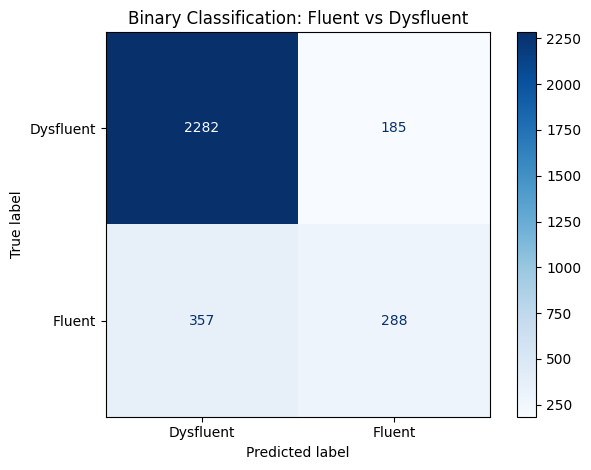

<Figure size 600x500 with 0 Axes>

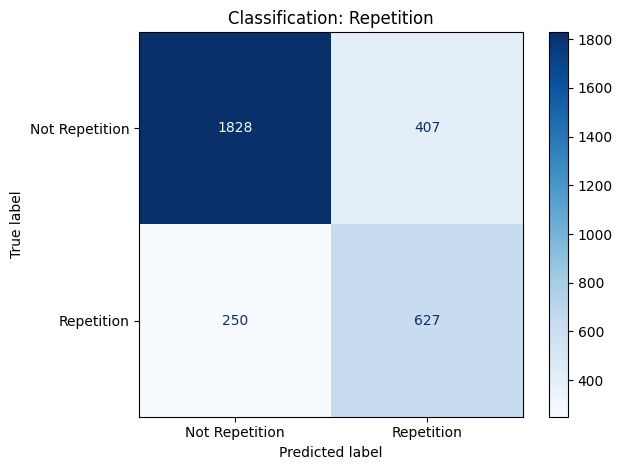

<Figure size 600x500 with 0 Axes>

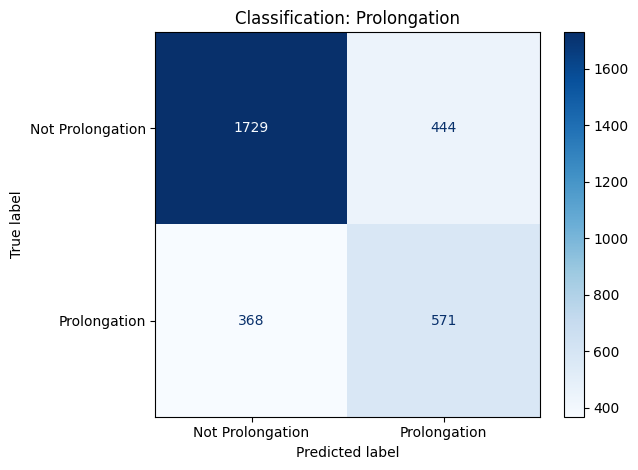

<Figure size 600x500 with 0 Axes>

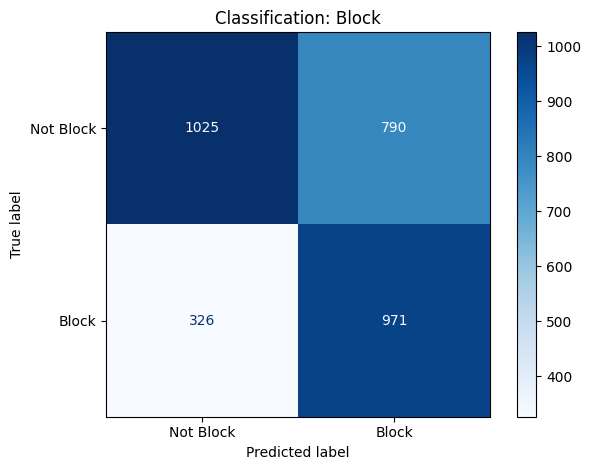

<Figure size 600x500 with 0 Axes>

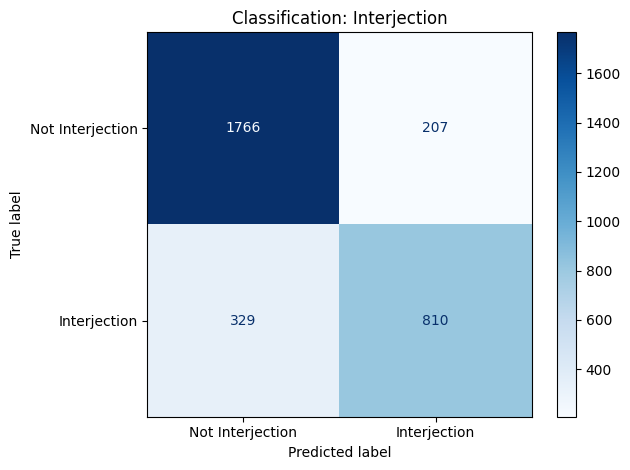

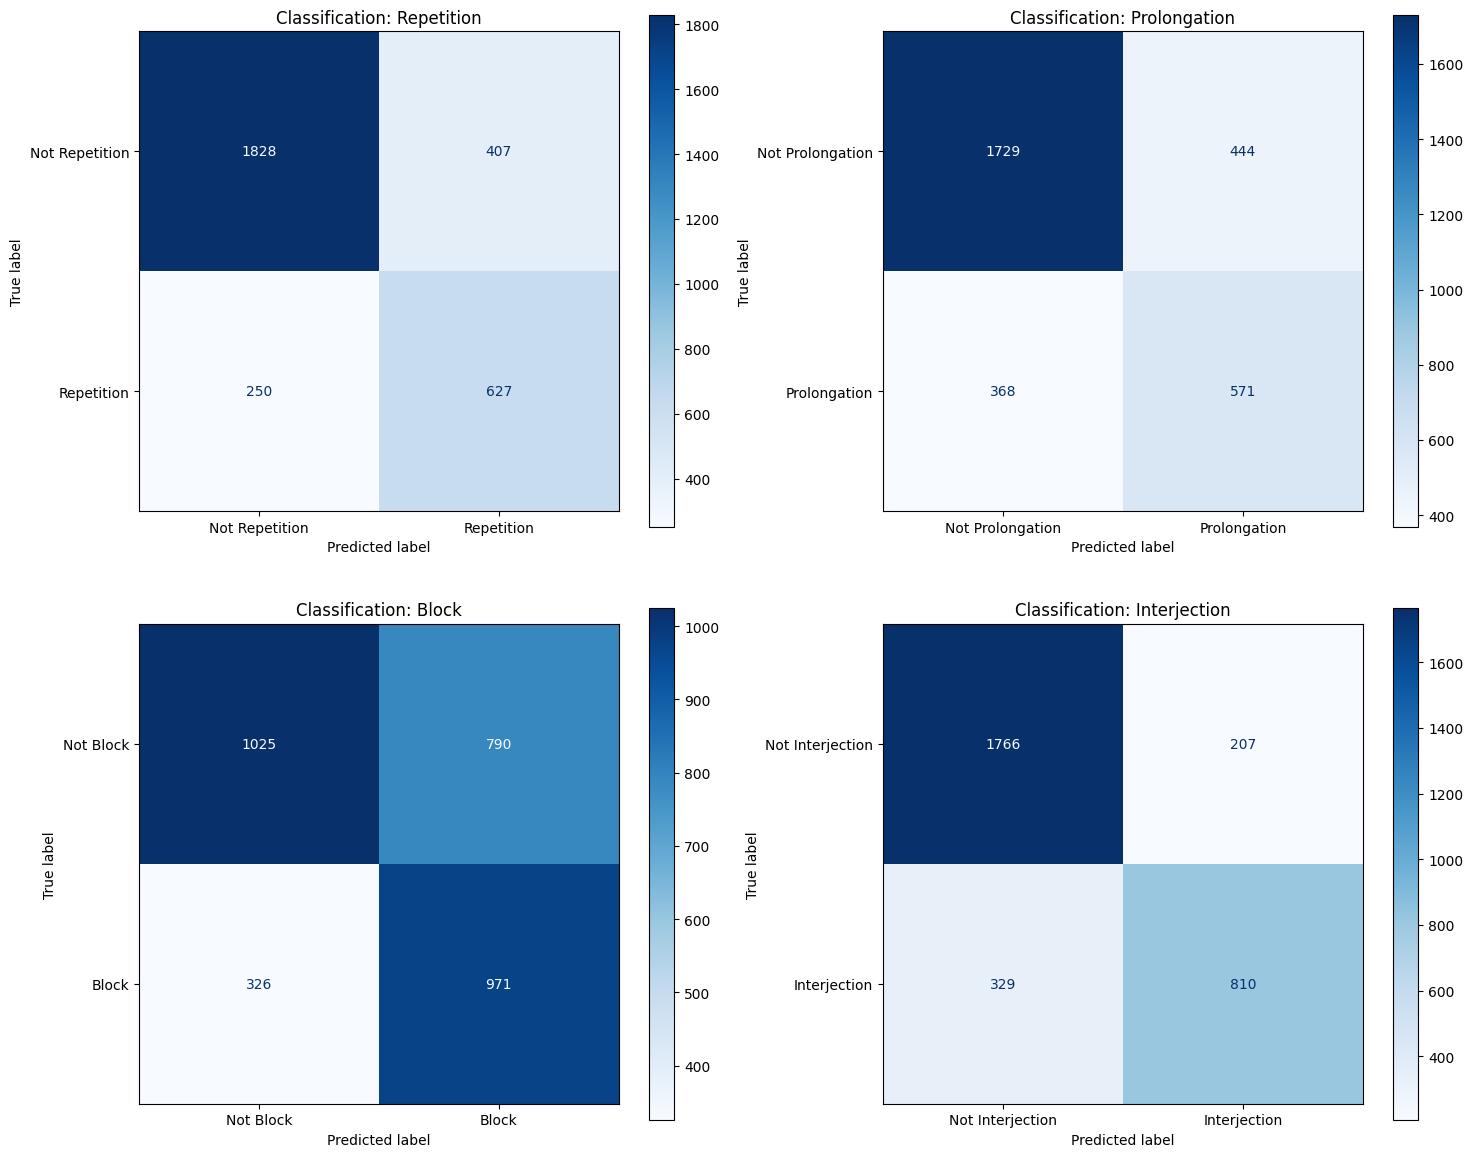

In [ ]:
print("\nGenerating confusion matrices for SEP-28k test set:")
plot_confusion_matrices_with_prefix(model, sep28k_test_dataloader, device, label_info['label_names'], prefix="sep28k")


Generating confusion matrices for FluencyBank test set:


Generating predictions for confusion matrices: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]


<Figure size 600x500 with 0 Axes>

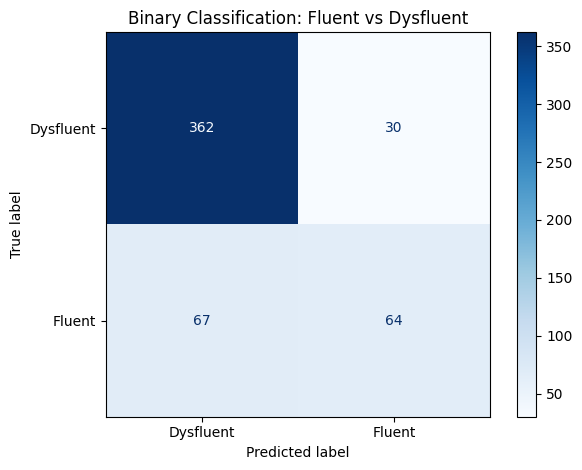

<Figure size 600x500 with 0 Axes>

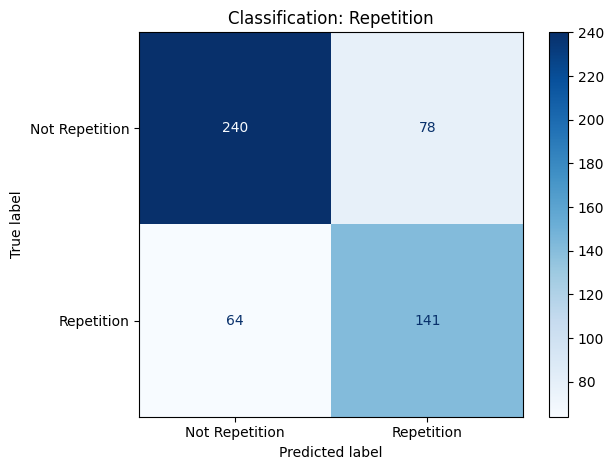

<Figure size 600x500 with 0 Axes>

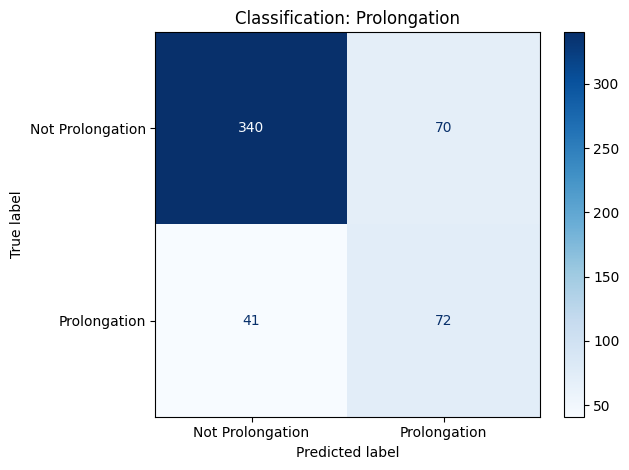

<Figure size 600x500 with 0 Axes>

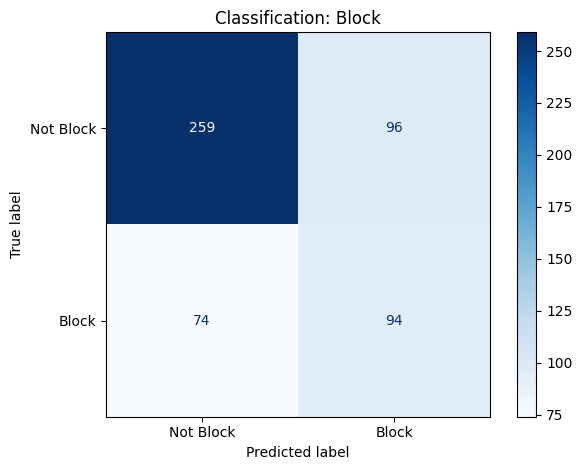

<Figure size 600x500 with 0 Axes>

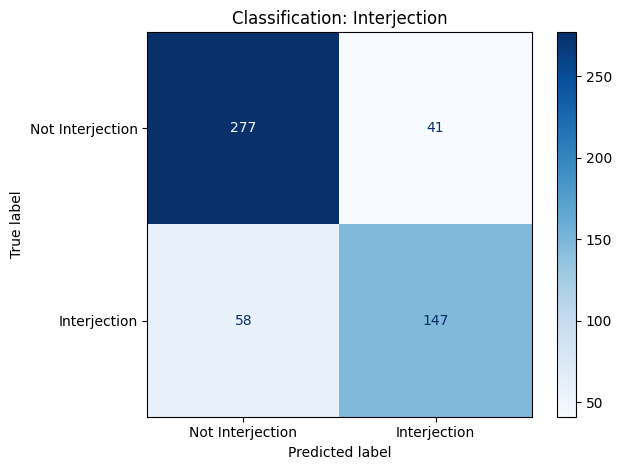

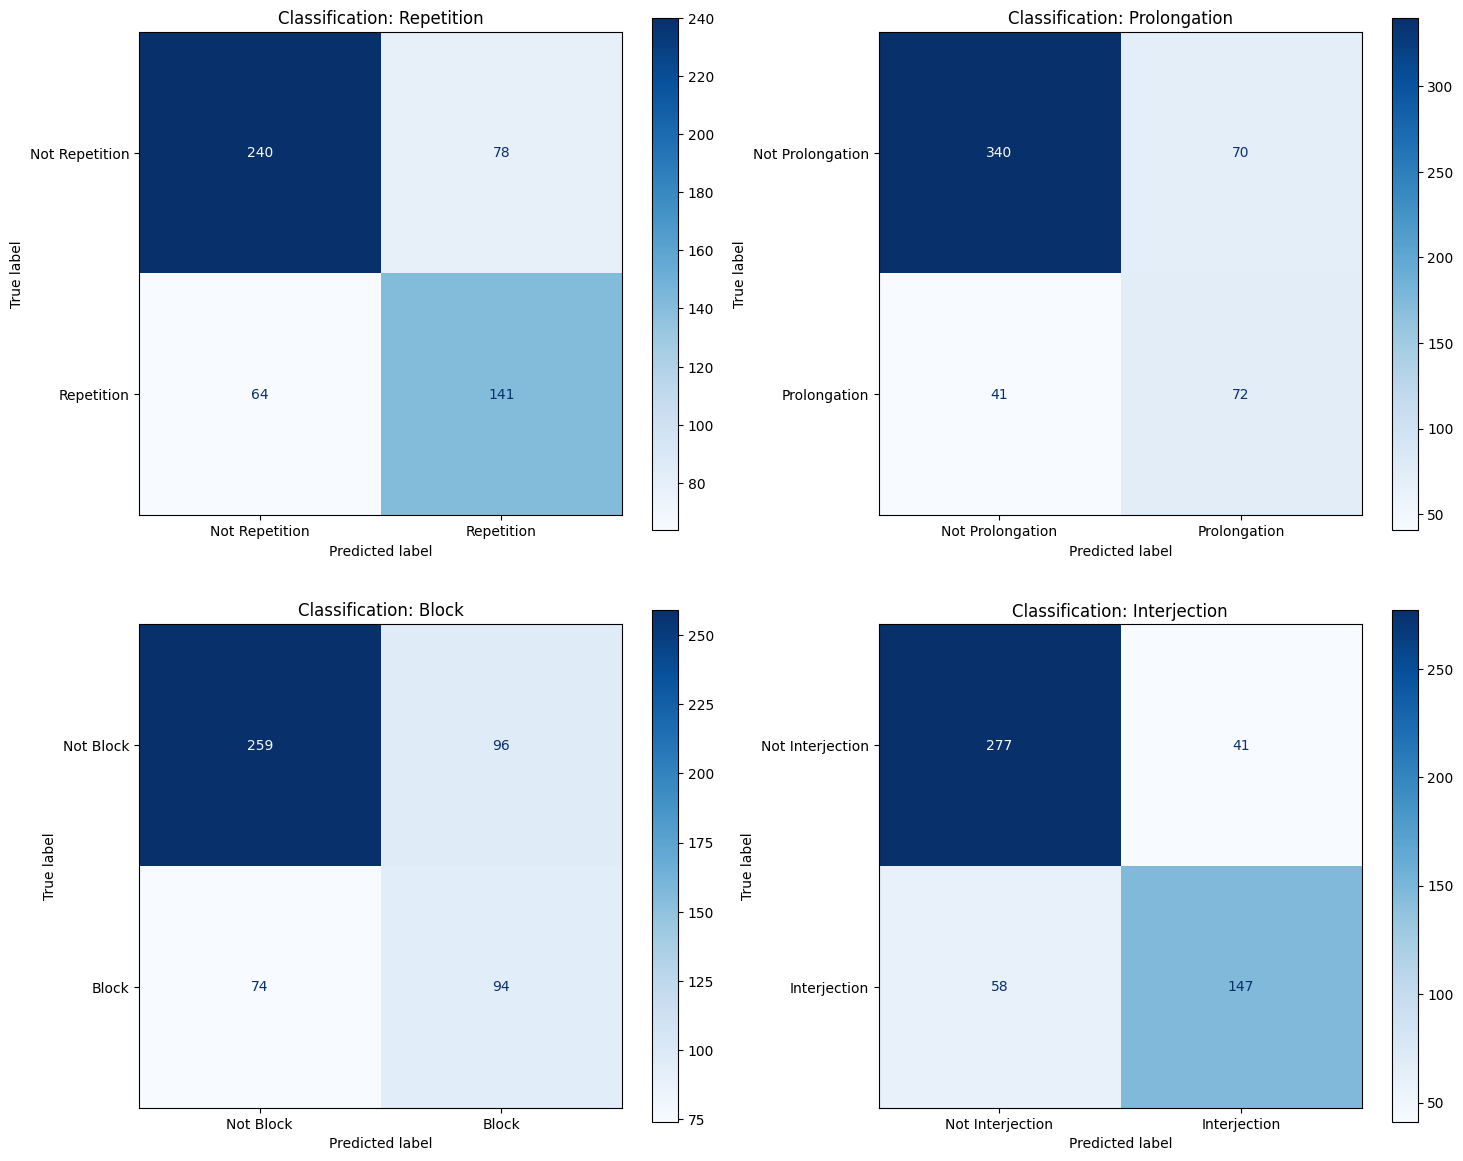

In [ ]:
print("\nGenerating confusion matrices for FluencyBank test set:")
plot_confusion_matrices_with_prefix(model, fluencybank_test_dataloader, device, label_info['label_names'], prefix="fluencybank")

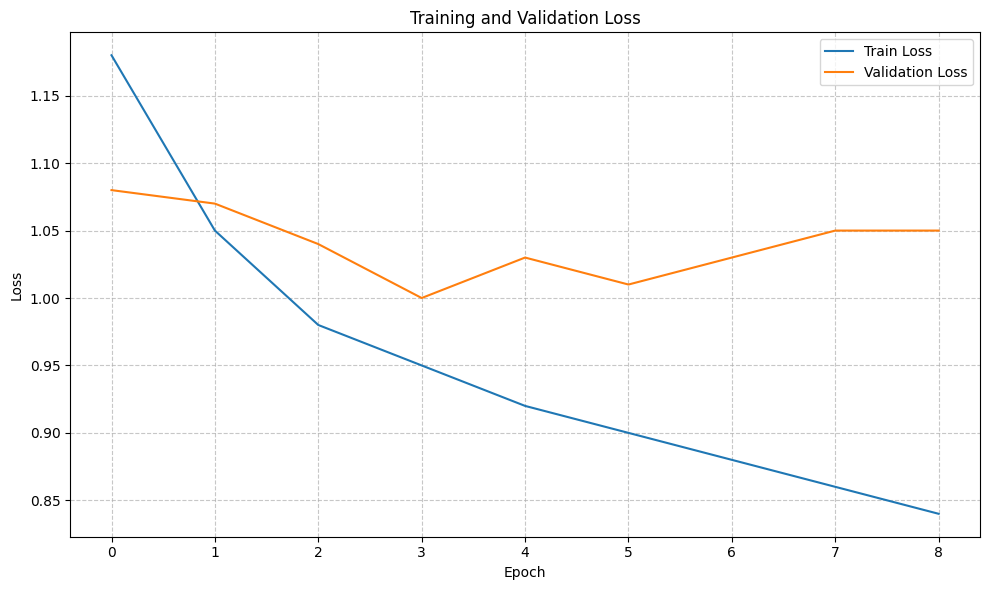

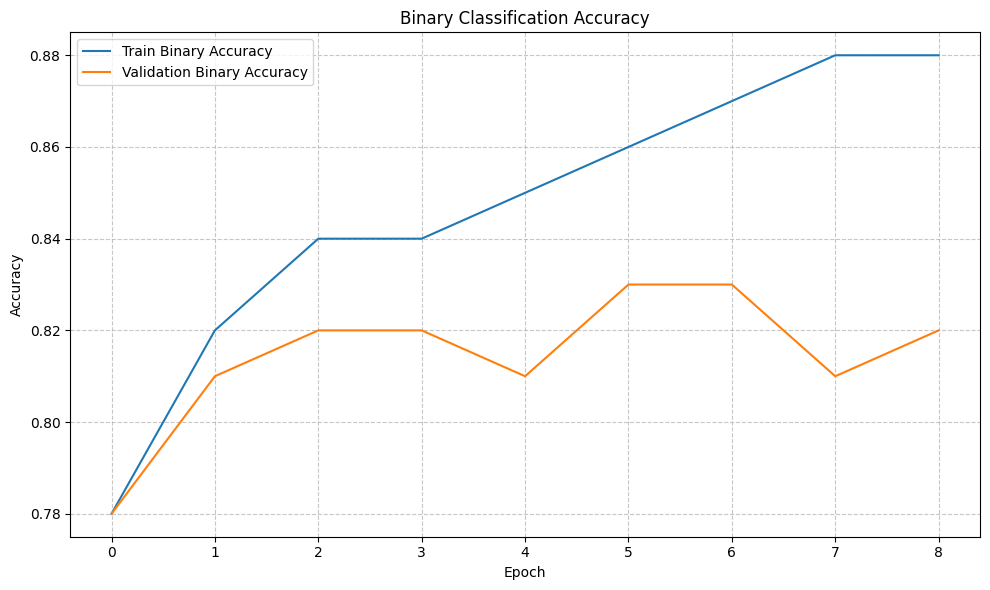

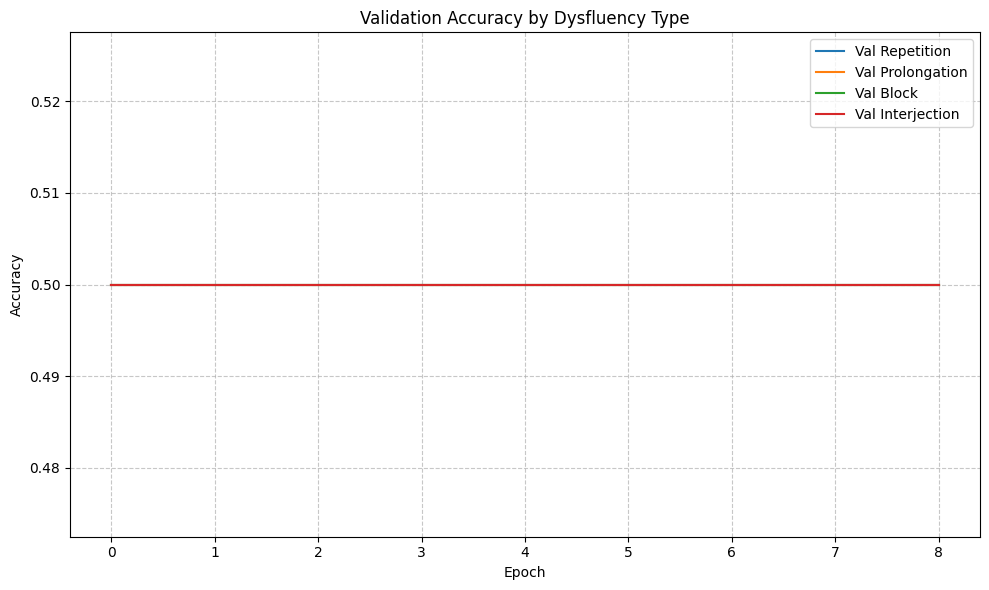

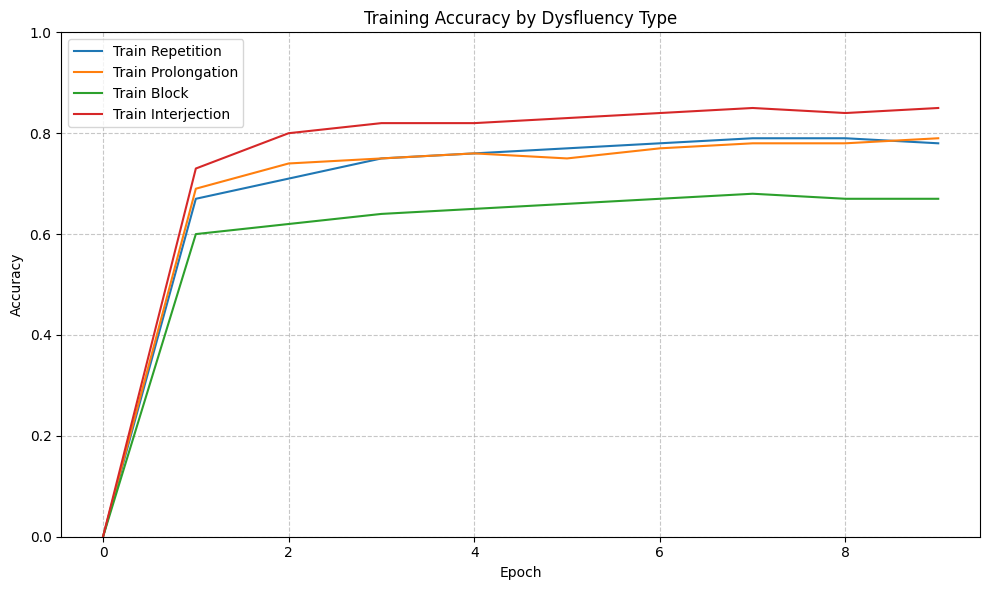

In [ ]:
# Assuming you have these metrics from your previous training run
train_losses = [1.18, 1.05, 0.98, 0.95, 0.92, 0.90, 0.88, 0.86, 0.84]
val_losses = [1.08, 1.07, 1.04, 1.00, 1.03, 1.01, 1.03, 1.05, 1.05]
train_binary_accuracies = [0.78, 0.82, 0.84, 0.84, 0.85, 0.86, 0.87, 0.88, 0.88]
val_binary_accuracies = [0.78, 0.81, 0.82, 0.82, 0.81, 0.83, 0.83, 0.81, 0.82]

# Dysfluency type training accuracies (assuming 4 types)
train_type_0 = [0.67, 0.71, 0.75, 0.76, 0.77, 0.78, 0.79, 0.79, 0.78]
train_type_1 = [0.69, 0.74, 0.75, 0.76, 0.75, 0.77, 0.78, 0.78, 0.79]
train_type_2 = [0.60, 0.62, 0.64, 0.65, 0.66, 0.67, 0.68, 0.67, 0.67]
train_type_3 = [0.73, 0.80, 0.82, 0.82, 0.83, 0.84, 0.85, 0.84, 0.85]

# Dysfluency type validation accuracies
val_type_0 = [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]
val_type_1 = [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]
val_type_2 = [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]
val_type_3 = [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50]

# Create the names for your types (replace with your actual label names)
label_names = ["Repetition", "Prolongation", "Block", "Interjection"]

# Number of epochs
num_epochs = len(train_losses)
epochs = list(range(num_epochs))

# Plot 1: Loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Training and Validation Loss')
plt.tight_layout()
# plt.savefig('loss_curves.png')
plt.show()

# Plot 2: Binary accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_binary_accuracies, label='Train Binary Accuracy')
plt.plot(epochs, val_binary_accuracies, label='Validation Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Binary Classification Accuracy')
plt.tight_layout()
# plt.savefig('binary_accuracy_curves.png')
plt.show()

# Plot 3: All dysfluency types in one plot (validation)
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_type_0, label=f'Val {label_names[0]}')
plt.plot(epochs, val_type_1, label=f'Val {label_names[1]}')
plt.plot(epochs, val_type_2, label=f'Val {label_names[2]}')
plt.plot(epochs, val_type_3, label=f'Val {label_names[3]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Validation Accuracy by Dysfluency Type')
plt.tight_layout()
# plt.savefig('validation_accuracy_by_type.png')
plt.show()

# Plot 4: All dysfluency types in one plot (training)
plt.figure(figsize=(10, 6))

# For training, prepend with 0 to show starting from origin
train_arrays = [
    [0] + train_type_0,
    [0] + train_type_1,
    [0] + train_type_2,
    [0] + train_type_3
]
# Create x-axis values including the 0 point
x_values = list(range(num_epochs + 1))

for i, label in enumerate(label_names):
    plt.plot(x_values, train_arrays[i], label=f'Train {label}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)  # Set y-axis to start from 0 and cap at 1.0
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Training Accuracy by Dysfluency Type')
plt.tight_layout()
# plt.savefig('training_accuracy_by_type.png')
plt.show()

-----

In [ ]:
# Load best model for evaluation
model = DysfluencyTransformerModel(num_specific_labels=4)
model.to(device)
model.load_state_dict(torch.load('best_dysfluency_model.pt'))
model.eval()

# Evaluate on SEP-28k test set
print("\nEvaluating on SEP-28k test set:")
sep28k_metrics = evaluate_model(model, sep28k_test_dataloader, device)

print("\nSEP-28k Test Results:")
print(f"Binary Accuracy: {sep28k_metrics['binary_accuracy']:.4f}")
print(f"Binary F1 Score: {sep28k_metrics['binary_f1']:.4f}")
print(f"Binary Precision: {sep28k_metrics['binary_precision']:.4f}")
print(f"Binary Recall: {sep28k_metrics['binary_recall']:.4f}")

print("\nMulti-label Classification for SEP-28k:")
print(f"Macro F1 Score: {sep28k_metrics['multi_f1']:.4f}")
print(f"Macro Precision: {sep28k_metrics['multi_precision']:.4f}")
print(f"Macro Recall: {sep28k_metrics['multi_recall']:.4f}")

print("\nPer-class F1 Scores for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'f1_{label}']:.4f}")

print("\nPer-class Accuracy for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'accuracy_{label}']:.4f}")

print("\nPer-class Precision for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'precision_{label}']:.4f}")

print("\nPer-class Recall for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'recall_{label}']:.4f}")

print("\nPer-class UAR for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'uar_{label}']:.4f}")

print("\nPer-class mAP for SEP-28k:")
for label in label_info['label_names']:
    print(f"{label}: {sep28k_metrics[f'map_{label}']:.4f}")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Evaluating on SEP-28k test set:


Evaluating: 100%|██████████| 98/98 [17:22<00:00, 10.64s/it]

Testing: bin f1 0.48392857142857143, mul f1 0.6480260742306791
Error calculating mAP for Repetition: name 'average_precision_score' is not defined
Error calculating mAP for Prolongation: name 'average_precision_score' is not defined
Error calculating mAP for Block: name 'average_precision_score' is not defined
Error calculating mAP for Interjection: name 'average_precision_score' is not defined

SEP-28k Test Results:
Binary Accuracy: 0.8143
Binary F1 Score: 0.4839
Binary Precision: 0.5705
Binary Recall: 0.4202

Multi-label Classification for SEP-28k:
Macro F1 Score: 0.6480
Macro Precision: 0.5935
Macro Recall: 0.7280

Per-class F1 Scores for SEP-28k:
Repetition: 0.6335
Prolongation: 0.5888
Block: 0.6028
Interjection: 0.7670

Per-class Accuracy for SEP-28k:
Repetition: 0.7725
Prolongation: 0.6719
Block: 0.6256
Interjection: 0.8323

Per-class Precision for SEP-28k:
Repetition: 0.5801
Prolongation: 0.4734
Block: 0.5403
Interjection: 0.7802

Per-class Recall for SEP-28k:
Repetition: 0.6978

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
# Add these imports at the top of your file if not already present
import gradio as gr
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Add this function to your code
def create_interface(model, device):
    # Load label information
    with open('/content/drive/MyDrive/mfcc_features/processed_features/label_info.json', 'r') as f:
        label_info = json.load(f)
    label_names = label_info['label_names']

    # Initialize processor
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    # Function to process audio and make predictions
    def detect_dysfluency(audio_file):
    # Load and process audio
        waveform, sample_rate = torchaudio.load(audio_file)

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if needed (Wav2Vec2 expects 16kHz)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            waveform = resampler(waveform)

        # Process with Wav2Vec2
        inputs = processor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt")
        input_values = inputs['input_values'].to(device)
        attention_mask = None

        # Run through model
        with torch.no_grad():
            binary_logits, multi_logits = model(input_values, attention_mask)

        # Convert to predictions
        binary_prob = torch.sigmoid(binary_logits).item()
        binary_pred = 1 if binary_prob >= 0.5 else 0

        multi_probs = torch.sigmoid(multi_logits).cpu().numpy()[0]
        multi_preds = (multi_probs >= 0.5).astype(int)

        # Format results
        binary_confidence = binary_prob if binary_pred == 1 else (1-binary_prob)
        binary_percentage = binary_confidence * 100

        # Create output text
        if binary_pred == 0:  # Fluent
            results = f"Fluent sample ({binary_percentage:.1f}%)"
        else:  # Dysfluent
            results = f"Dysfluent sample ({binary_percentage:.1f}%)\n\n"

            # Add dysfluency types
            for i, (label, pred, prob) in enumerate(zip(label_names, multi_preds, multi_probs)):
                percentage = prob * 100
                results += f"{label}: ({percentage:.1f}%)\n"

        return results

        # Create Gradio interface
    with gr.Blocks() as interface:
        gr.Markdown("# Speech Dysfluency Detection")
        gr.Markdown("Upload an audio file to detect dysfluencies")

        with gr.Row():
            with gr.Column():
                audio_input = gr.Audio(type="filepath", label="Upload Audio")
                detect_button = gr.Button("Detect Dysfluency")

            with gr.Column():
                # waveform_output = gr.Image(label="Waveform")
                results_output = gr.Textbox(label="Detection Results", lines=10)

        detect_button.click(
            fn=detect_dysfluency,
            inputs=[audio_input],
            outputs=[results_output]
        )

    return interface

# Add this at the end of your script, after training and evaluation
if __name__ == "__main__":
    # Your existing training and evaluation code here

    # Load your best model for the interface
    model = DysfluencyTransformerModel(num_specific_labels=len(label_info['label_names']))
    #model.load_state_dict(torch.load('final_combined_model.pt'))
    model = model.to(device)
    model.eval()

    # Create and launch the interface
    print("Training and evaluation complete. Starting interface...")
    interface = create_interface(model, device)
    interface.launch(share=True,debug=True)  # share=True creates a public link

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training and evaluation complete. Starting interface...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5ec00278bc555547c0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
